# Создание и обучение модели классификации эмоций лица

In [1]:
import tensorflow as tf
print('tensorflow version', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot.tf_keras import PlotLossesCallback

tensorflow version 2.4.1


In [2]:
# !pip install --upgrade tensorflow_hub

In [1]:
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import time
from pathlib import Path
from matplotlib import pyplot as plt
from misc.custom_filters import random_transformation

plt.rcParams['figure.facecolor'] = 'white' # for better plots in dark notebook themes

Создадим вспомогательные функции для загрузки датасета и тестирования модели.

In [3]:
def load_dataset(n, batch_size, image_size):
    """
    Create image generators for train and test data with specified parameters.
    """
    base_dir = Path('dataset')
    df_train = pd.read_pickle(base_dir / f'dataframe_case{n}_train.pkl')
    df_test = pd.read_pickle(base_dir / f'dataframe_case{n}_test.pkl')

    if n == 1:
        image_generator = ImageDataGenerator(
            rescale=1./255, 
            rotation_range=15, 
            width_shift_range=0.15,
            height_shift_range=0.10,
            brightness_range=(0.6, 1.4),
            shear_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True,
            preprocessing_function=random_transformation,
        )
    elif n == 2:
        image_generator = ImageDataGenerator(
            rescale=1./255, 
            rotation_range=15, 
            width_shift_range=0.05,
            height_shift_range=0.05,
            brightness_range=(0.6, 1.4),
            shear_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True,
            preprocessing_function=random_transformation,
        )
    else:
        raise ValueError('n should be integer and equal to 1 or 2.')
    
    val_generator = ImageDataGenerator(rescale=1./255)

    train_data_gen = image_generator.flow_from_dataframe(
        df_train,
        directory=base_dir,
        x_col='image_path',
        y_col='emotion',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
        interpolation='bicubic',
        validate_filenames=False,
    )
    val_data_gen = val_generator.flow_from_dataframe(
        df_test,
        directory=base_dir,
        x_col='image_path',
        y_col='emotion',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True, # useful if we limit validation steps
        interpolation='bicubic',
        validate_filenames=False,
    )
    
    assert train_data_gen.class_indices == val_data_gen.class_indices, "Class labels doesn't match between train and test sets."
    labels_dict = {v: k for k,v in train_data_gen.class_indices.items()}
    
    return train_data_gen, val_data_gen, labels_dict


def benchmark_model(model, sample, iterations=200):
    """Test inference time of the model."""
    model(sample) # warm-up inference
    inference_times = []
    for i in range(iterations):
        start = time.time()
        model(sample)
        inference_times.append(time.time() - start)
    mean_time = np.mean(inference_times)
    median_time = np.median(inference_times)
    plt.plot(inference_times)
    plt.title(f'Inference time over {iterations} iterations on one picture\n'
              f'mean time = {mean_time:.3f}sec, median time = {median_time:.3f}sec')
    plt.xlabel('Iteration number')
    plt.ylabel('Inference time, sec')
    plt.show()
    return mean_time, median_time


def show_examples(data_gen):
    x, y = next(data_gen)

    plt.figure(figsize=(15,15))
    plt.suptitle('Quick check of genereted images').set_y(0.92)
    for i in range(25):
        img = x[i]
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(labels_dict[np.argmax(y[i])])
        plt.xticks([]); plt.yticks([])
    plt.show()

## Вариант 1 (оригинальные фотографии)

### Загрузка и подготовка данных

Загрузим фатафреймы для обучающей и валидационной выборок

In [7]:
train_data_gen, val_data_gen, labels_dict = load_dataset(n=1, batch_size=256, image_size=299)

Found 39634 non-validated image filenames belonging to 9 classes.
Found 9905 non-validated image filenames belonging to 9 classes.


Создадим генераторы изображений

In [8]:
train_data_gen.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7,
 'uncertain': 8}

Посмотрим, не слишком ли мы исказили данные (главое, чтобы глаза и рот попадали в кадр, так как во многом именно они позволяют определить эмоцию)

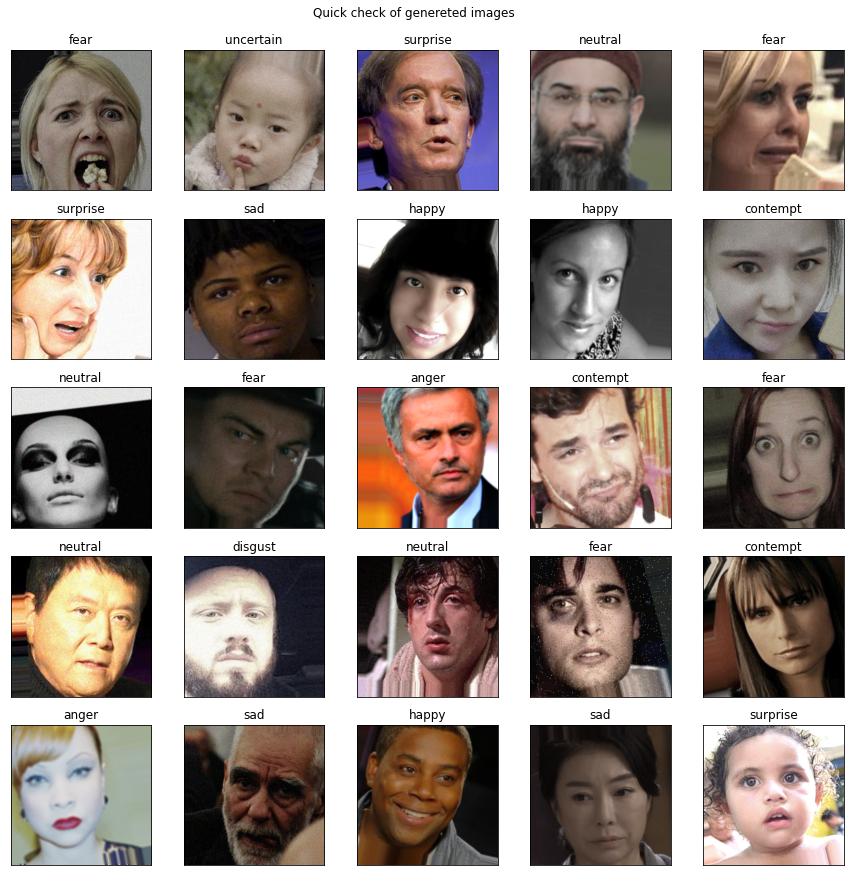

In [10]:
show_examples(train_data_gen)

### Создание и обучение модели

В качестве основы модели будем использовать предобученную CNN. Опробуем несколько подходов к дообучению модели, в частности Fine-tuning и Feature extracting (отбросив другие подходы (d, e) как неактуальные, так как мы полностью отбрасываем ImageNet голову):

![виды дообучения](misc/types_finetuning.png)

#### 1. Inception_v3 - Feature Extraction

для начала попробуем модель [Inception_v3 by Google](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4) c дообучением на feature extraction. Размер изображения на входе этой модели достаточно близкое к медианному размеру изображений в обучающем датасете. Добавим скрытый слой с вдвое меньшим количеством нейронов, чем размер вектора признаков на выходе из предобученной сети, также для уменьшения вероятности переобучения и большей обобщающей способности сети, добовим Dropout на выходе скрытого слоя. Для более простого инференса модели в продакшн, проименуем вход и выход.

In [11]:
N_CLASSES = len(train_data_gen.class_indices)
LEARNING_RATE = 0.001
HIDDEN_UNITS = 1024 # basically a half of classifier output

In [13]:
# True to create model, False - to load model for continue with training
if True:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(299, 299, 3), name='input'),
        hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048],
                       trainable=False),
        tf.keras.layers.Dense(HIDDEN_UNITS, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output')
    ])

    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()

    chpt_dir = Path('models/inception_v3/')
    chpt_dir.mkdir(parents=True, exist_ok=True)
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt2', save_best_only=True, monitor='val_loss')
else:
    chpt_dir = Path('models/inception_v3/')
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt2', save_best_only=True, monitor='val_loss')
    model = tf.keras.models.load_model(chpt_dir / 'chpt2')
    print(f"Checkpoint {chpt_dir / 'chpt2'} was loaded.")
    model.layers[0].trainable = False
    model.summary()

Checkpoint models/inception_v3/chpt2 was loaded.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 9)                 9225      
Total params: 23,910,185
Trainable params: 2,107,401
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
epochs_counter = 0

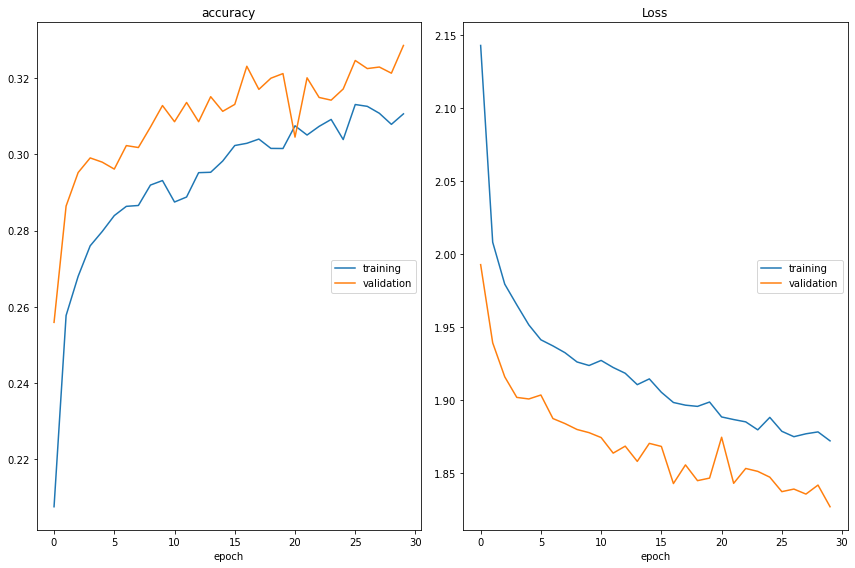

accuracy
	training         	 (min:    0.208, max:    0.313, cur:    0.311)
	validation       	 (min:    0.256, max:    0.329, cur:    0.329)
Loss
	training         	 (min:    1.872, max:    2.143, cur:    1.872)
	validation       	 (min:    1.827, max:    1.993, cur:    1.827)
INFO:tensorflow:Assets written to: models/inception_v3/chpt2/assets


INFO:tensorflow:Assets written to: models/inception_v3/chpt2/assets


In [14]:
EPOCHS = 30
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
#     use_multiprocessing=True
)
epochs_counter += EPOCHS

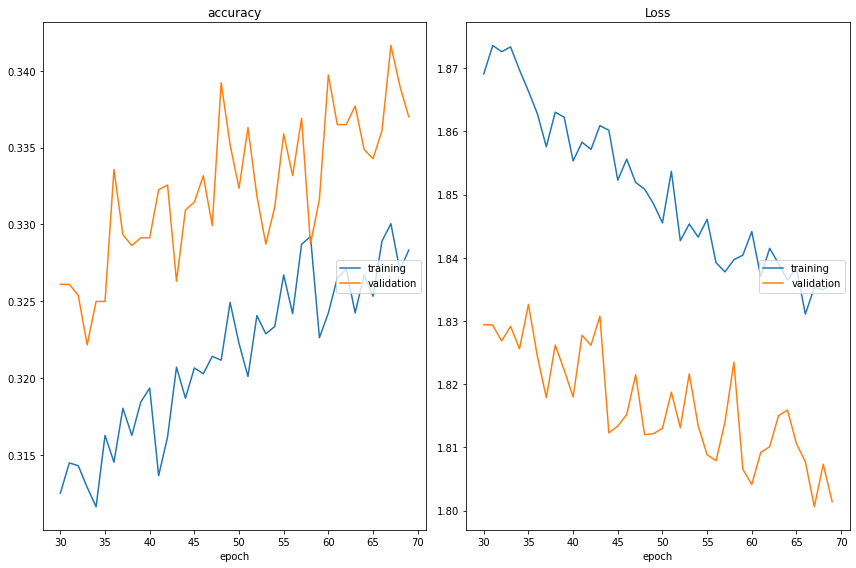

accuracy
	training         	 (min:    0.312, max:    0.330, cur:    0.328)
	validation       	 (min:    0.322, max:    0.342, cur:    0.337)
Loss
	training         	 (min:    1.831, max:    1.874, cur:    1.836)
	validation       	 (min:    1.801, max:    1.833, cur:    1.801)


In [15]:
EPOCHS = 40
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
#     use_multiprocessing=True
)
epochs_counter += EPOCHS

Загрузим модель с наименьшим значением функции потерь на валидационной выборке.

In [16]:
model = tf.keras.models.load_model(chpt_dir / 'chpt2')

In [14]:
# model evaluation on case1 images
model.evaluate(val_data_gen, workers=4)

39/39 [==============================] - 105s 2s/step - loss: 1.8006 - accuracy: 0.3416


[1.800621509552002, 0.34164562821388245]

In [16]:
# optional model evaluation on case2 images 
# (after overwriting val_data_gen with dataframe_case2_test data)
_, val_data2_gen, _ = load_dataset(n=2, batch_size=256, image_size=299)
model.evaluate(val_data2_gen, workers=4)  

Found 39999 non-validated image filenames belonging to 9 classes.
Found 9996 non-validated image filenames belonging to 9 classes.
40/40 [==============================] - 36s 870ms/step - loss: 1.7694 - accuracy: 0.3488


[1.7694196701049805, 0.34883952140808105]

Измерим скорость инференса (наша цель примерно < 150 ms на colab)

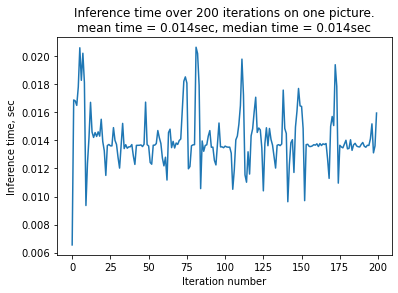

(0.014100967645645142, 0.013700127601623535)

In [27]:
x, y = next(train_data_gen)
sample = x[0:1]
benchmark_model(model, sample)

#### 2. BiT model with BiT HyperRule fine-tuning ([link](https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html)).

Следующим вариантом обучим BiT (Big Transfer) сеть, которая создавалась для дообучения под различные задачи. В качастве основы возьмем BiT-M r50x1 модель (архитектура ResNet-50, веса обученны на ImageNet-21k (также известный как "полный ImageNet, релиз осени 2011"). Отличием BiT модели от ResNet является применение стандартизации ядра сверточных слоев, т.е. свертка применяется с ядром (kernel-mean)/var вместо kernel, а так же использованием GroupNormalization (GN) вместо BatchNormalization (BN) при распределенном обучении на ImageNet-21k.

In [5]:
BATCH_SIZE = 64
IMG_SIZE = 200

train_data_gen, val_data_gen, labels_dict = load_dataset(
    n=1, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE
)

Found 39634 non-validated image filenames belonging to 9 classes.
Found 9905 non-validated image filenames belonging to 9 classes.


In [6]:
N_CLASSES = len(train_data_gen.class_indices)

In [8]:
if True:
    model = tf.keras.Sequential([
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input'),
            hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
#             tf.keras.layers.Dense(HIDDEN_UNITS, activation='relu', kernel_initializer='zeros'),
#             tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output', kernel_initializer='zeros')
        ])
  
    # BiT HyperRule
    lr = 0.003 * BATCH_SIZE / 512 
    SCHEDULE_LENGTH = 2500 * 512 / BATCH_SIZE # 10 epochs = 30% of SCHEDULE_LENGTH
    SCHEDULE_BOUNDARIES = [int(SCHEDULE_LENGTH * x) for x in [0.3, 0.6, 0.9]] 
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=SCHEDULE_BOUNDARIES, 
        values=[lr, lr*0.1, lr*0.001, lr*0.0001]
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()

    chpt_dir = Path('models/bit-m/')
    chpt_dir.mkdir(parents=True, exist_ok=True)
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt1', save_best_only=True, monitor='val_loss')
else:
    chpt_dir = Path('models/bit-m/')
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt1', save_best_only=True, monitor='val_loss')
    model = tf.keras.models.load_model(chpt_dir / 'chpt1')
    print(f"Checkpoint {chpt_dir / 'chpt1'} was loaded.")
    model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
output (Dense)               (None, 9)                 18441     
Total params: 23,518,793
Trainable params: 23,518,793
Non-trainable params: 0
_________________________________________________________________


In [9]:
epochs_counter = 0

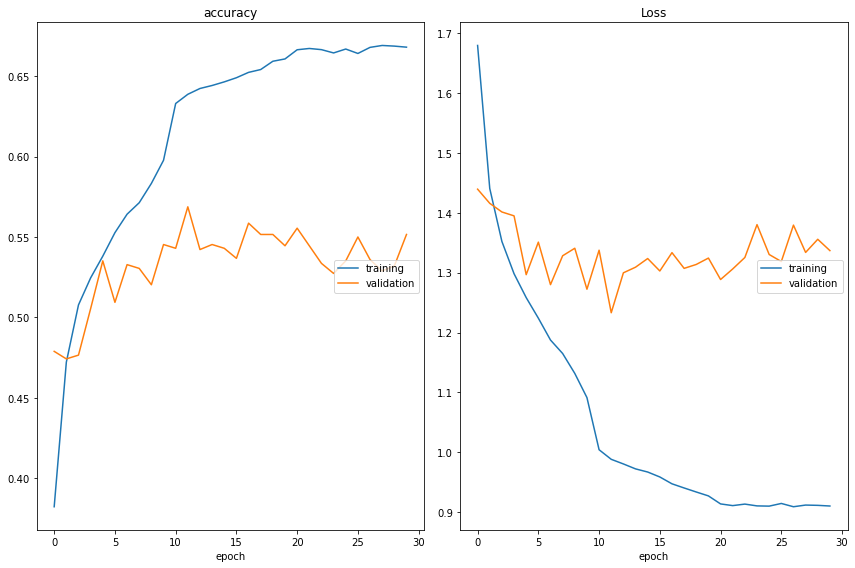

accuracy
	training         	 (min:    0.382, max:    0.669, cur:    0.668)
	validation       	 (min:    0.474, max:    0.569, cur:    0.552)
Loss
	training         	 (min:    0.909, max:    1.679, cur:    0.910)
	validation       	 (min:    1.233, max:    1.439, cur:    1.337)


In [10]:
EPOCHS = 30
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
#     use_multiprocessing=True
    validation_steps=20, # for memory constrains
)
epochs_counter += EPOCHS

Минимум функции потерь на валидационной выборке пришелся на 11 эпоху, так что, возможно, значение `SCHEDULE_LENGTH = 2500 * 512 / BATCH_SIZE` было избыточным, что учтем на следующем датасете.

In [12]:
model.save(chpt_dir / 'chpt_last')

INFO:tensorflow:Assets written to: models/bit-m/chpt_last/assets


INFO:tensorflow:Assets written to: models/bit-m/chpt_last/assets


Загрузим лучший чекпоинт:

In [14]:
model = tf.keras.models.load_model(chpt_dir / 'chpt1')
print(f"{chpt_dir / 'chpt1'} checkpoint loaded.")

models/bit-m/chpt1 checkpoint loaded.


In [15]:
model.evaluate(val_data_gen, workers=4)

155/155 [==============================] - 49s 304ms/step - loss: 1.2927 - accuracy: 0.5462


[1.2927305698394775, 0.5461887717247009]

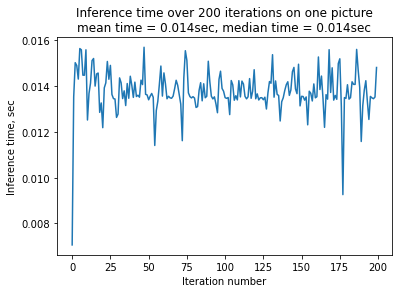

(0.013767964839935302, 0.013619065284729004)

In [20]:
x, y = next(train_data_gen)
sample = x[0:1]
benchmark_model(model, sample)

## Вариант 2 (лица, обрезанные детектором лиц)

### Загрузка и подготовка данных

In [18]:
IMG_SIZE = 299
train_data_gen, val_data_gen, labels_dict = load_dataset(n=2, batch_size=256, image_size=IMG_SIZE)

Found 39999 non-validated image filenames belonging to 9 classes.
Found 9996 non-validated image filenames belonging to 9 classes.


Генераторы изображений необходимо изменить, например у нас практически нет места для сдвига по вертикали и/или горизонтали.

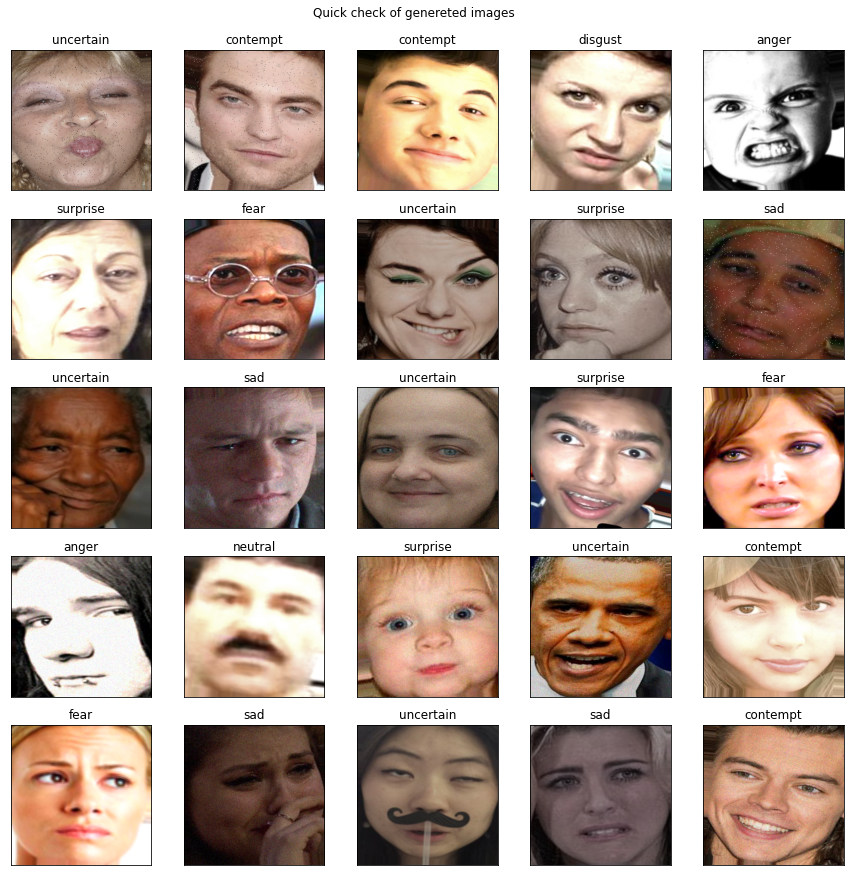

In [20]:
show_examples(train_data_gen)

Несмотря на искажения пропорций лица, всё лицо помещяется на изображении и эмоции всё равно можно определить.

### Создание и обучение модели

Для сравнения двух датасетов подходы по дообучению моделей менять не будем

#### 1. Inception_v3 - feature extraction на датасете case2.

In [7]:
N_CLASSES = len(train_data_gen.class_indices)
LEARNING_RATE = 0.001
HIDDEN_UNITS = 1024 # basically a half of classifier output

In [8]:
# True to create model, False - to load model for continue with training
if True:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input'),
        hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048],
                       trainable=False),
        tf.keras.layers.Dense(HIDDEN_UNITS, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output')
    ])

    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()

    chpt_dir = Path('models/inception_v3_ds2/')
    chpt_dir.mkdir(parents=True, exist_ok=True)
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt2', save_best_only=True, monitor='val_loss')
else:
    chpt_dir = Path('models/inception_v3_ds2/')
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt2', save_best_only=True, monitor='val_loss')
    model = tf.keras.models.load_model(chpt_dir / 'chpt2')
    model.layers[0].trainable = False
    print(f"Checkpoint {chpt_dir / 'chpt2'} was loaded.")
    model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 9)                 9225      
Total params: 23,910,185
Trainable params: 2,107,401
Non-trainable params: 21,802,784


In [9]:
epochs_counter = 0

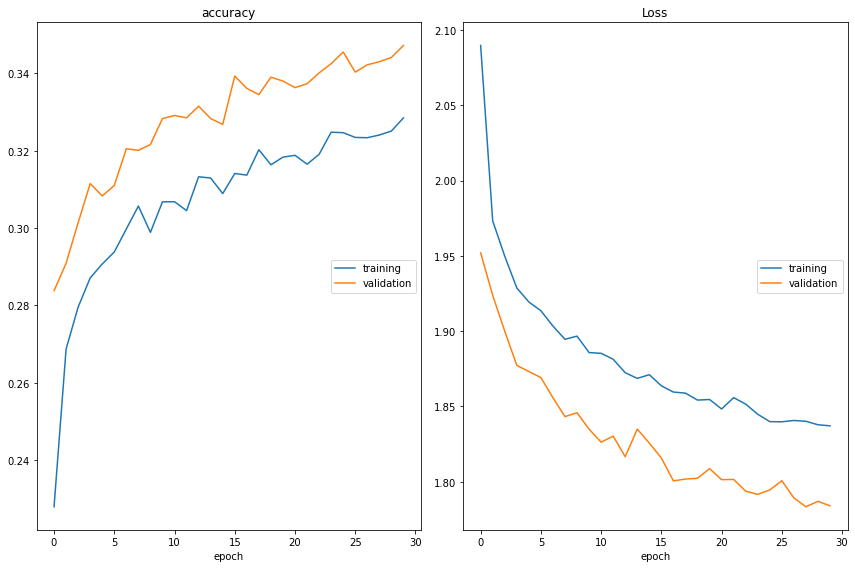

accuracy
	training         	 (min:    0.228, max:    0.329, cur:    0.329)
	validation       	 (min:    0.284, max:    0.347, cur:    0.347)
Loss
	training         	 (min:    1.837, max:    2.090, cur:    1.837)
	validation       	 (min:    1.783, max:    1.952, cur:    1.784)


In [10]:
EPOCHS = 30
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
#     use_multiprocessing=True
)
epochs_counter += EPOCHS

In [14]:
chpt_dir = Path('models/inception_v3_ds2/')
model = tf.keras.models.load_model(chpt_dir / 'chpt2')
print(f"{chpt_dir / 'chpt2'} checkpoint loaded.")

models/inception_v3_ds2/chpt2 checkpoint loaded.


In [107]:
# evaluate loaded model
model.evaluate(val_data_gen, workers=4)

40/40 [==============================] - 36s 870ms/step - loss: 1.7834 - accuracy: 0.3430


[1.7834020853042603, 0.3430372178554535]

In [18]:
# testing case2 trained model on va_data_gen made of case1 files.
_, val_data1_gen, _ = load_dataset(n=1, batch_size=256, image_size=299)
model.evaluate(val_data1_gen, workers=4)

39/39 [==============================] - 83s 2s/step - loss: 1.8748 - accuracy: 0.3065


[1.8747661113739014, 0.30651184916496277]

Вывод из сравнения case1 и case2 датасетов (без обрезки и с обрезкой лица):
- Классификатор на Inception_v3 работает достаточно быстро: инференс 14ms на GFX-1080 и достаточно легкая (116 MB).
- Inception_v3 на case1 датасете показала accuracy: 0.3416 после 70 эпох. 
- Inception_v3 на case2 датасете показала accuracy: 0.3430 после 30 эпох.
- Та же модель при меньшем количестве итераций обучения добилась чуть большей точности и есть потенциал роста на несколько процентов при дальнейшем обучении на обрезанных лицах (2-ой датасет).
- Модель, обученная на оригинальных изображениях показала точность на 0.0072 выше при тестировании на обрезанных фотографиях (что является незначительной разницей, т.е. модель работает с одинаковым качеством как на оригинальных фотографиях, так и на обрезанных детектором лиц).
- Модель, обученная на обрезанных лицах показала точность на 0.0365 хуже при тестировании на оригинальных фотографиях, т.е. при обучении на обрезанных лицах модель менее способна к обобщению (возможно, что просто из-за меньшего количества эпох).

Так как в любом случае данных подход дает значительно более низкое качество, чем у BiT + fine-tuning, дальнейшее обучение этого случая является нецелесообразным.

#### 2. BiT model with BiT HyperRule fine-tuning, обучение на обрезанных изображениях (после детектора лиц)

In [8]:
BATCH_SIZE = 64
IMG_SIZE = 240

train_data_gen, val_data_gen, labels_dict = load_dataset(
    n=2, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE
)

Found 39999 non-validated image filenames belonging to 9 classes.
Found 9996 non-validated image filenames belonging to 9 classes.


In [9]:
N_CLASSES = len(train_data_gen.class_indices)

if True:
    model = tf.keras.Sequential([
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input'),
            hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
            tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output', kernel_initializer='zeros')
        ])
  
    # BiT HyperRule
    lr = 0.003 * BATCH_SIZE / 512 
    SCHEDULE_LENGTH = 1700 * 512 / BATCH_SIZE # 11 epochs = 50% of SCHEDULE_LENGTH
    SCHEDULE_BOUNDARIES = [int(SCHEDULE_LENGTH * x) for x in [0.3, 0.6, 0.9]] 
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=SCHEDULE_BOUNDARIES, 
        values=[lr, lr*0.1, lr*0.001, lr*0.0001]
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()

    chpt_dir = Path('models/bit-m_ds2/')
    chpt_dir.mkdir(parents=True, exist_ok=True)
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt1', save_best_only=True, monitor='val_loss')
else:
    chpt_dir = Path('models/bit-m_ds2/')
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt1', save_best_only=True, monitor='val_loss')
    model = tf.keras.models.load_model(chpt_dir / 'chpt1')
    print(f"Checkpoint {chpt_dir / 'chpt1'} was loaded.")
    model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
output (Dense)               (None, 9)                 18441     
Total params: 23,518,793
Trainable params: 23,518,793
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs_counter = 0

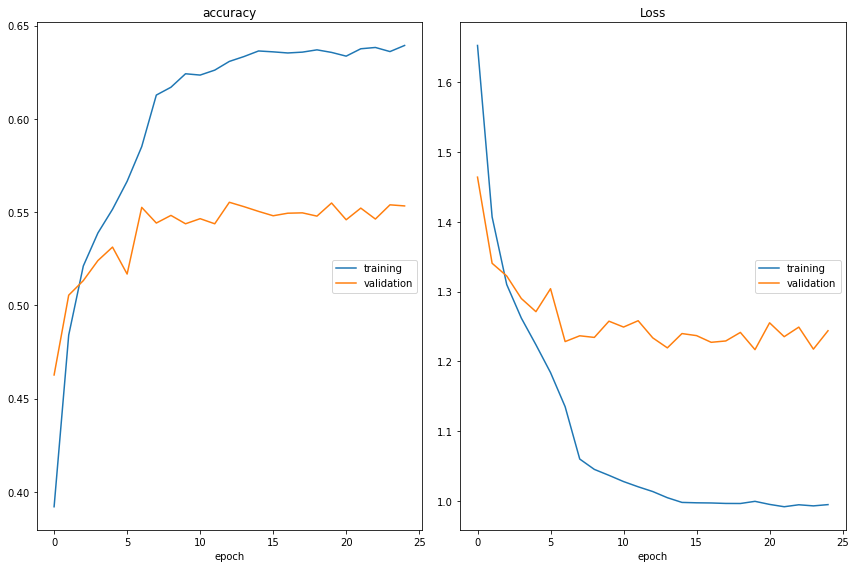

accuracy
	training         	 (min:    0.392, max:    0.639, cur:    0.639)
	validation       	 (min:    0.463, max:    0.555, cur:    0.553)
Loss
	training         	 (min:    0.991, max:    1.653, cur:    0.995)
	validation       	 (min:    1.217, max:    1.464, cur:    1.244)


In [11]:
EPOCHS = 25
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
    validation_steps=80, # for memory constrains
)
epochs_counter += EPOCHS

In [13]:
model.save(chpt_dir / 'chpt_last')

INFO:tensorflow:Assets written to: models/bit-m_ds2/chpt_last/assets


INFO:tensorflow:Assets written to: models/bit-m_ds2/chpt_last/assets


In [14]:
chpt_dir = Path('models/bit-m_ds2/')
model = tf.keras.models.load_model(chpt_dir / 'chpt1')
print(f"{chpt_dir / 'chpt1'} checkpoint loaded.")
# best chpt
model.evaluate(val_data_gen, workers=4)

models/bit-m_ds2/chpt1 checkpoint loaded.


In [16]:
chpt_dir = Path('models/bit-m_ds2/')
model = tf.keras.models.load_model(chpt_dir / 'chpt_last')
print(f"{chpt_dir / 'chpt_last'} checkpoint loaded.")
model.evaluate(val_data_gen, workers=4)

models/bit-m_ds2/chpt_last checkpoint loaded.
157/157 [==============================] - 70s 434ms/step - loss: 1.2396 - accuracy: 0.5512


[1.2396026849746704, 0.5512204766273499]

По скольку для экономии памяти валидация при обучении проводилась на половиде валидационной выборки, то лучший чекпоинт определился не очень точно. Далее в качестве лучшего чекпоинта будем использовать `chpt_last`.

In [17]:
# testing case2 trained model on va_data_gen made of case1 files.
_, val_data1_gen, _ = load_dataset(n=1, batch_size=64, image_size=240)
model.evaluate(val_data1_gen, workers=4)

Found 39634 non-validated image filenames belonging to 9 classes.
Found 9905 non-validated image filenames belonging to 9 classes.
155/155 [==============================] - 94s 602ms/step - loss: 1.2120 - accuracy: 0.5594


[1.2119992971420288, 0.5594144463539124]

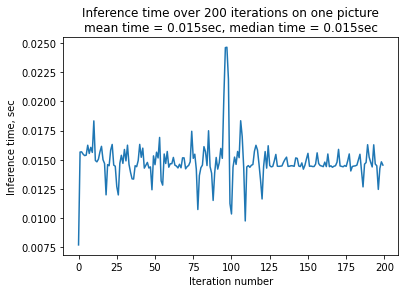

(0.014845974445343017, 0.014606833457946777)

In [22]:
x, y = next(train_data_gen)
sample = x[0:1]
benchmark_model(model, sample)

Итоги сравнения BiT-M r50x1 модели обученной на друх датасетах (оригинальный и с обрезанными лицами):
- BiT-M r50x1 модель на изображениях размера 240х240 работает также быстро как и Inception_v3 - 0.015ms на GFX-1080.
- BiT-M модель показала точность на валидационной выборке accuracy: 0.5462 на оригинальных фотографиях (case1)
- BiT-M модель показала точность на валидационной выборке accuracy: 0.5512 на обрезанных фотографиях (case2)
- Модель обученная на обрезанных лицах показала чуть лучшую точность на валидационном сете из оригинальных фотографий, чем на обрезанных фотографиях (BiT_ds2 on case1 -> 0.5594, BiT_ds2 on case2 -> 0.5512 accuracy).

Обобщая исследования 2 моделей на 2 датасетах, лучшим выбором стала модель models/bit-m_ds2/chpt_last (BiT обученная на обрезанных лицах).

### Дополнительные исслдедования.

#### 1. Inception with fine-tuning.

Попробуем обучить Inception_v3 модель на case2 датасете по технике BiT-HyperRule (fine-tuning вместо feature extraction) для полноты картины.

In [5]:
BATCH_SIZE = 50
IMG_SIZE = 299

train_data_gen, val_data_gen, labels_dict = load_dataset(n=2, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

N_CLASSES = len(train_data_gen.class_indices)

Found 39999 non-validated image filenames belonging to 9 classes.
Found 9996 non-validated image filenames belonging to 9 classes.


In [6]:
# True to create model, False - to load model for continue with training
if True:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input'),
        hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048],
                       trainable=True),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output', kernel_initializer='zeros')
    ])
  
    # BiT HyperRule
    lr = 0.003 * BATCH_SIZE / 512
    SCHEDULE_LENGTH = 2000 * 512 / BATCH_SIZE # 11 epochs = 50% of SCHEDULE_LENGTH
    EPOCHS = int(SCHEDULE_LENGTH / (39999 / BATCH_SIZE))
    SCHEDULE_BOUNDARIES = [int(SCHEDULE_LENGTH * x) for x in [0.3, 0.6, 0.9]] 
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=SCHEDULE_BOUNDARIES, 
        values=[lr, lr*0.1, lr*0.01, lr*0.001] # chpt 
        #values=[lr, lr*0.5, lr*0.1, lr*0.01]
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()

    chpt_dir = Path('models/inception_v3_hyper_rule/')
    chpt_dir.mkdir(parents=True, exist_ok=True)
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt1', save_best_only=True, monitor='val_loss')
else:
    chpt_dir = Path('models/inception_v3_hyper_rule/')
    chpt = tf.keras.callbacks.ModelCheckpoint(chpt_dir / 'chpt1', save_best_only=True, monitor='val_loss')
    model = tf.keras.models.load_model(chpt_dir / 'chpt1')
    print(f"Checkpoint {chpt_dir / 'chpt1'} was loaded.")
    model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
output (Dense)               (None, 9)                 18441     
Total params: 21,821,225
Trainable params: 21,786,793
Non-trainable params: 34,432
_________________________________________________________________


In [8]:
epochs_counter = 0

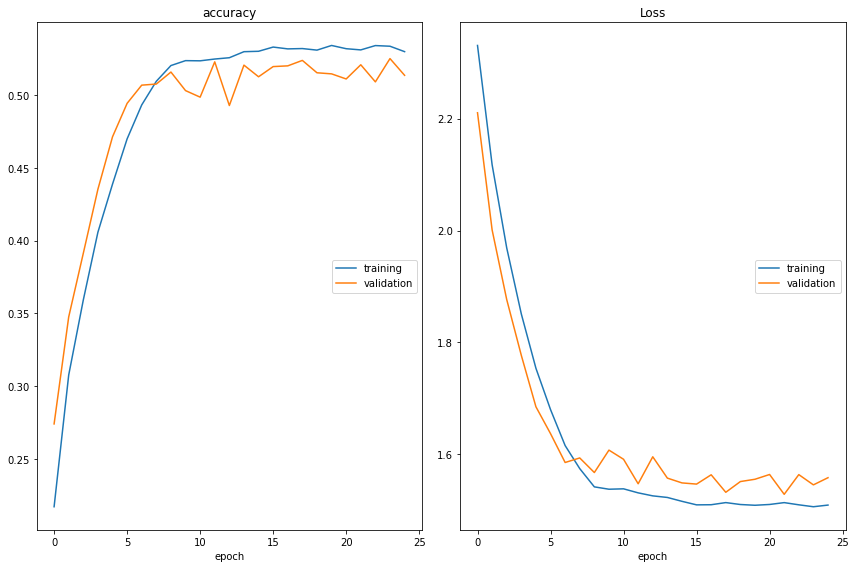

accuracy
	training         	 (min:    0.217, max:    0.534, cur:    0.530)
	validation       	 (min:    0.274, max:    0.525, cur:    0.513)
Loss
	training         	 (min:    1.507, max:    2.331, cur:    1.510)
	validation       	 (min:    1.529, max:    2.210, cur:    1.558)


In [14]:
EPOCHS = 25
history = model.fit(
    train_data_gen,
    epochs=epochs_counter + EPOCHS,
    initial_epoch=epochs_counter,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), chpt], 
    workers=4, 
    validation_steps=80, # for memory constrains
)
epochs_counter += EPOCHS

Судя по резкому замедлению скорости падения loss, можно сделать вывод, что предложенное расписание изменений learning rate слишком кардинальное (в 10 раз уменьшать на каждом этапе). Можно сделать еще одну попытку обучения с менее резкой скоростью уменьшения lr.

Оценим модель на полной валидационной выборке.

In [16]:
# best checkpoint evaluation
chpt_dir = Path('models/inception_v3_hyper_rule/')
model = tf.keras.models.load_model(chpt_dir / 'chpt1')
print(f"Checkpoint {chpt_dir / 'chpt1'} was loaded.")
model.evaluate(val_data_gen, workers=4)

Checkpoint models/inception_v3_hyper_rule/chpt1 was loaded.
200/200 [==============================] - 38s 183ms/step - loss: 1.5526 - accuracy: 0.5173


[1.5526129007339478, 0.517306923866272]

In [17]:
# testing case2 trained model on va_data_gen made of case1 files.
_, val_data1_gen, _ = load_dataset(n=1, batch_size=50, image_size=299)
model.evaluate(val_data1_gen, workers=4)

Found 39634 non-validated image filenames belonging to 9 classes.
Found 9905 non-validated image filenames belonging to 9 classes.
199/199 [==============================] - 63s 316ms/step - loss: 1.6586 - accuracy: 0.4737


[1.6586434841156006, 0.4737001657485962]

In [22]:
# create config file
import configparser

config = configparser.ConfigParser()
config['MODEL'] = {
    'name': 'inception_v3_hyper_rule',
    'dataset': 'case2',
    'checkpoint': 'chpt1'
}
config['IMAGE'] = {
    'size': IMG_SIZE,
    'format': 'RGB',
    'scale': '1 / 255',
}
config['LABELS'] = train_data_gen.class_indices

with open(chpt_dir / 'config.ini', 'w') as configfile:
    config.write(configfile)

В целом, модель Inception также хорошо поддается дообучению с fine-tuning, как и BiT, показав результат на несколько процентов хуже. Рекомендуется проводить подбор графика снижения скорости обучения, так как предложенный в BiT-HyperRule коэффициент снижения скорости обучения (в 10 раз) на 30%, 60%, 90% прогресса обучения может оказаться слишком большим.

Отдельно отметим, что Inception модель аказалась более чувствительной к размеру лица на фотографии: модель, обученная на обрезанных лицах, показала точность на 0.045 меньше на оригинальном датасете.